## Preprocess EMR data in a batch with Amazon SageMaker with Amazon Textrect and Comprehend


---

---

## Contents

1. [Objective](#Objective)
1. [Background](#Background)
1. [Prepare Environment](#Prepare-Environment)
1. [Download Data](#Download-and-Explore-Data)
1. [Pipeline for analysis with Amazon services](#Analysis-with-Comprehend)
   + Remove samples with missing transcription
   + Check for data distribution
   + Process-of-single-record-with-Comprehend-Medical
   + Data Sampling for Modeling
   + Process with Comprehend Medical
   + Explore medical conditions
   
1. [Save the File](#Save-the-File)

---
## Objective 
This notebook is the preprocessing step to prepare a batch of medical records for model training. Specifically, you will use Comprehend Medical to extract medical terms from doctors's transcripts and organize them into data frame.  

---
## Background 

- **Dataset**: Medical transcription data scraped from *mtsamples.com*. The target in the preprocess is to extract the medical conditions from doctors' notes, and then organized into dataset for modeling. In the next step, we will use the processed dataset to correctly classify the medical specialties based on the transcription text. In real life, the model can be used for automatic reference to respective specialist. 

- **Amazon Comprehend Medical** : Comprehend Medical detects useful information in unstructured clinical text. As much as 75% of all health record data is found in unstructured text such as physician's notes, discharge summaries, test results, and case notes. Amazon Comprehend Medical uses Natural Language Processing (NLP) models to sort through text for valuable information. 

- **Supported Languages** : Amazon Comprehend Medical only detects medical entities in English language texts.

---
## Prepare-Environment

We'll need to:

- **import** some useful libraries (as in any Python notebook)
- **configure** the S3 bucket and folder where data should be stored (to keep our environment tidy)
- **connect** to Amazon Comprehend(with [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)) and SageMaker in particular (with the [sagemaker SDK](https://sagemaker.readthedocs.io/en/stable/)), to use the cloud services

Note: While `boto3` is the general AWS SDK for Python, `sagemaker` provides some powerful, higher-level interfaces designed specifically for ML workflows.

In [17]:
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
pd.set_option('display.max_colwidth', None)

import time
import os
from util.preprocess import *  # helper function for classification reports

# setting up SageMaker parameters
import sagemaker
import boto3

import matplotlib.pyplot as plt
import seaborn as sns

boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "emr-mtSample"  # Location in the bucket to store our files
sgmk_session = sagemaker.Session()

sgmk_client = boto_session.client("sagemaker")  ## API for sagemaker
cm_client  = boto3.client(service_name='comprehendmedical', use_ssl=True, region_name = 'us-east-1') ## API for comprehend medical


---
## Download-and-Explore-Data


* The raw dataset is available at [kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions). Refer to the descriptions for more information. In this workshop, we have already downloaded the dataset in your local folder `./data/mtsample.csv`

**Columns in the dataset**:

* `description`: Short description of transcription (string)
* `medical_specialty`: Medical specialty classification of transcription (string)
* `sample_name`: Transcription title
* `transcription`: Sample medical transcriptions
* `keywords`: Relevant keywords from transcription

`transcription` column is the column transcribed from doctors' notes and it embeded most useful information. Here, we will use Amazon Comprehend Medical to to extract the medical information from this column. On the other side, `medical_specialty` is the target column for classification purpose. 


In [ ]:
df=pd.read_csv("./data/mtsamples.csv")
df.head()

description  \
0   A 23-year-old white female presents with complaint of allergies.   
1                           Consult for laparoscopic gastric bypass.   
2                           Consult for laparoscopic gastric bypass.   
3                                             2-D M-Mode. Doppler.     
4                                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

---
## Pipeline-for-Analysis

####  Firstly, check for missing information with the columns and remove the missing rows

In [19]:
df.isnull().sum(axis=0) 

description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

####  Secondly, check for distribution of medical speciality

<<<<<<< local <modified: text/plain>


>>>>>>> remote <modified: text/plain>


<<<<<<< local


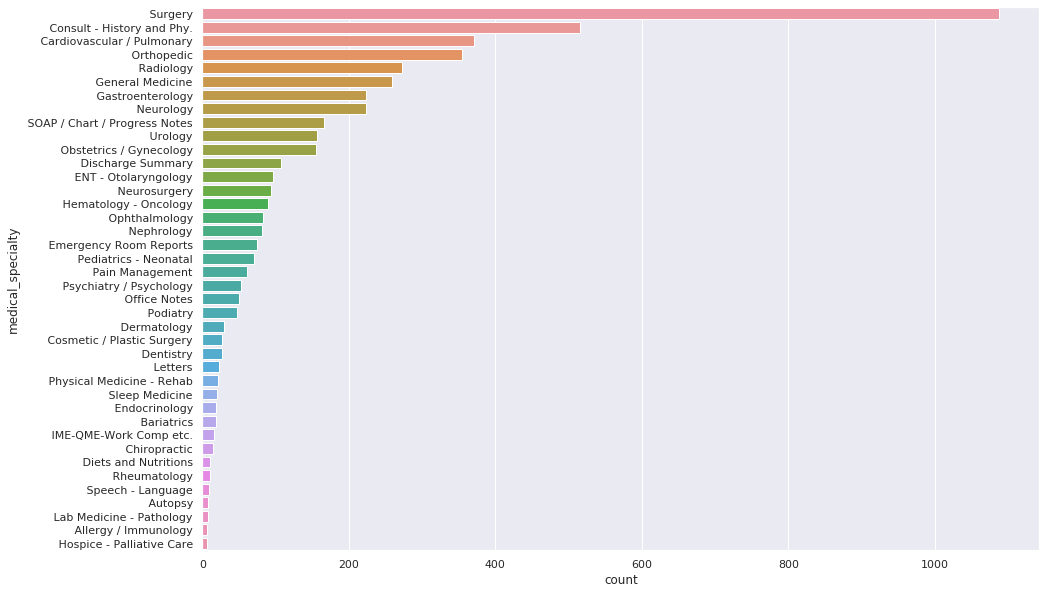

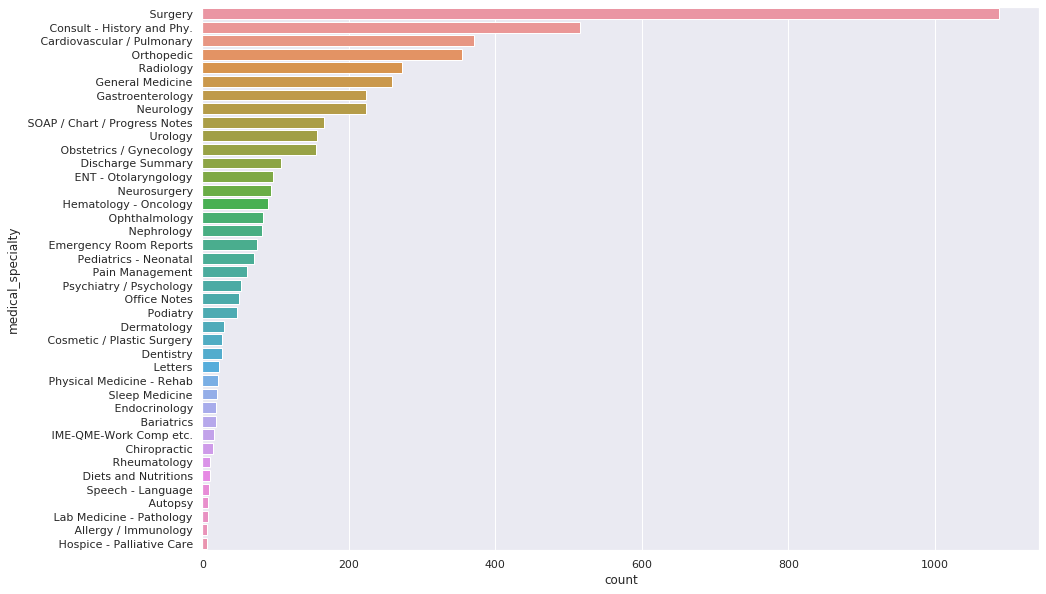

>>>>>>> remote


In [ ]:
## add patient_id for reference
df=df[df.transcription.isnull()==False].reset_index()
df['id']=df.index
sns.set(rc={'figure.figsize':(15,10)})
sns.countplot(y='medical_specialty',order=df['medical_specialty'].value_counts().index, data=df)  #df.medical_specialty.value_counts()

## Process-of-single-record-with-Comprehend-Medical

Using Amazon Comprehend Medical, you can quickly and accurately gather information, such as medical condition, medication, dosage, strength, and frequency from a variety of sources like doctors’ notes. Amazon Comprehend Medical uses advanced machine learning models to accurately and quickly identify medical information, such as medical conditions and medications, and determines their relationship to each other, for instance, medicine dosage and strength. Amazon Comprehend Medical can also link the detected information to medical ontologies such as ICD-10-CM or RxNorm. 
![Image of Comprehend Medical](https://d1.awsstatic.com/diagrams/product-page-diagram-Ontology-Linking_How-It-Works@2x.f2dde99f71240451d64b24bdd202573ff9a26d35.png)


Here, we use comprehend API [Detect Entities (Version 2)](https://docs.aws.amazon.com/comprehend/latest/dg/extracted-med-info-V2.html). DetectEntitiesV2 examine unstructured clinical text to detect textual references to medical information such as medical condition, treatment, tests and results, and medications. This version uses a new model and changes the way some entities are returned in the output. For more information, see [DetectEntitiesV2](https://docs.aws.amazon.com/comprehend/latest/dg/API_medical_DetectEntitiesV2.html).

In [27]:
%%time 
from util.preprocess import *

notes=df.transcription[0]
print(color.BOLD+"Transcript from Doctor: \n"+ color.END,notes )
response = cm_client.detect_entities_v2(Text=notes)
df_transcription = pd.DataFrame(response['Entities'])
df_transcription.head(10)

Transcript from Doctor: 
 SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Su

,Id,BeginOffset,EndOffset,Score,Text,Category,Type,Traits,Attributes
0,33,19,21,0.997357,23,PROTECTED_HEALTH_INFORMATION,AGE,[],NaN
1,20,71,80,0.540678,allergies,MEDICAL_CONDITION,DX_NAME,[],NaN
2,34,128,135,0.999592,Seattle,PROTECTED_HEALTH_INFORMATION,ADDRESS,[],NaN
3,42,173,184,0.999642,In the past,TIME_EXPRESSION,TIME_TO_MEDICATION_NAME,[],"[{'Type': 'BRAND_NAME', 'Score': 0.9996567964553833, 'RelationshipScore': 0.7792145609855652, 'RelationshipType': 'OVERLAP', 'Id': 6, 'BeginOffset': 200, 'EndOffset': 208, 'Text': 'Claritin', 'Category': 'MEDICATION', 'Traits': []}]"
4,42,173,184,0.999642,In the past,TIME_EXPRESSION,TIME_TO_MEDICATION_NAME,[],"[{'Type': 'BRAND_NAME', 'Score': 0.9991027116775513, 'RelationshipScore': 0.6068645119667053, 'RelationshipType': 'OVERLAP', 'Id': 7, 'BeginOffset': 214, 'EndOffset': 220, 'Text': 'Zyrtec', 'Category': 'MEDICATION', 'Traits': []}]"
5,6,200,208,0.999657,Claritin,MEDICATION,BRAND_NAME,[],NaN
6,7,214,220,0.999103,Zyrtec,MEDICATION,BRAND_NAME,[],NaN
7,21,269,287,0.493933,lose effectiveness,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'SYMPTOM', 'Score': 0.74055016040802}]",NaN
8,8,303,310,0.998393,Allegra,MEDICATION,BRAND_NAME,[],NaN
9,35,337,343,0.891146,summer,PROTECTED_HEALTH_INFORMATION,DATE,[],NaN


### List all the medical conditions related with the record

* `BeginOffset`- The 0-based character offset in the input text that shows where the entity begins. 
* `EndOffset`-The 0-based character offset in the input text that shows where the entity ends. 
* `Score`-The level of confidence that Amazon Comprehend Medical has in the accuracy of the detection.
* `Text`-The segment of input text extracted as this entity
* `Category`-The category of the entity.
* `Traits`-Contextual information for the entity.

In the following steps, we will use Category to extract items belong to *`MEDICAL_CONDITION`*, and then use inofmation *`Text`* and *`Score`* for prediction.   

In [31]:
df_mc[df_mc.Category=='MEDICAL_CONDITION']

,Id,BeginOffset,EndOffset,Score,Text,Category,Type,Traits,Attributes
1,20,71,80,0.540678,allergies,MEDICAL_CONDITION,DX_NAME,[],NaN
7,21,269,287,0.493933,lose effectiveness,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'SYMPTOM', 'Score': 0.74055016040802}]",NaN
10,22,520,526,0.996238,asthma,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'DIAGNOSIS', 'Score': 0.8697242736816406}]",NaN
19,23,843,855,0.909276,erythematous,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'SIGN', 'Score': 0.868060290813446}]","[{'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.989835798740387, 'RelationshipScore': 0.9934899806976318, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 0, 'BeginOffset': 813, 'EndOffset': 818, 'Text': 'HEENT', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9972782731056213, 'RelationshipScore': 0.9995998740196228, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 1, 'BeginOffset': 825, 'EndOffset': 831, 'Text': 'throat', 'Category': 'ANATOMY', 'Traits': []}]"
20,24,864,871,0.961924,exudate,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'SIGN', 'Score': 0.9362218976020813}, {'Name': 'NEGATION', 'Score': 0.8823236227035522}]","[{'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.989835798740387, 'RelationshipScore': 0.9962068796157837, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 0, 'BeginOffset': 813, 'EndOffset': 818, 'Text': 'HEENT', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9972782731056213, 'RelationshipScore': 0.99391770362854, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 1, 'BeginOffset': 825, 'EndOffset': 831, 'Text': 'throat', 'Category': 'ANATOMY', 'Traits': []}]"
22,25,891,903,0.971652,erythematous,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'SIGN', 'Score': 0.892443060874939}]","[{'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.989835798740387, 'RelationshipScore': 0.9788709878921509, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 0, 'BeginOffset': 813, 'EndOffset': 818, 'Text': 'HEENT', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9723161458969116, 'RelationshipScore': 0.9999657869338989, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 2, 'BeginOffset': 874, 'EndOffset': 886, 'Text': 'Nasal mucosa', 'Category': 'ANATOMY', 'Traits': []}]"
23,26,908,915,0.995261,swollen,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'SIGN', 'Score': 0.926656186580658}]","[{'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.989835798740387, 'RelationshipScore': 0.9857694506645203, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 0, 'BeginOffset': 813, 'EndOffset': 818, 'Text': 'HEENT', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9723161458969116, 'RelationshipScore': 0.9991655349731445, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 2, 'BeginOffset': 874, 'EndOffset': 886, 'Text': 'Nasal mucosa', 'Category': 'ANATOMY', 'Traits': []}]"
24,27,923,937,0.589994,clear drainage,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'SIGN', 'Score': 0.8746218085289001}]","[{'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.989835798740387, 'RelationshipScore': 0.992547333240509, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 0, 'BeginOffset': 813, 'EndOffset': 818, 'Text': 'HEENT', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9723161458969116, 'RelationshipScore': 0.7484143972396851, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 2, 'BeginOffset': 874, 'EndOffset': 886, 'Text': 'Nasal mucosa', 'Category': 'ANATOMY', 'Traits': []}]"
26,28,949,963,0.812802,TMs were clear,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'SIGN', 'Score': 0.9362046718597412}]","[{'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.989835798740387, 'RelationshipScore': 0.9862160682678223, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 0, 'BeginOffset': 813, 'EndOffset': 818, 'Text': 'HEENT', 'Category': 'ANATOMY', 'Traits': []}]"
28,29,972,978,0.989609,Supple,MEDICAL_CONDITION,DX_NAME,"[{'Name': 'SIGN', 'Score': 0.9601727724075317}]","[{'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9988210797309875, 'RelationshipScore': 0.7589898109436035, 'Rel

## Data-Sampling-for-Modeling
* For demo purpose, We will select 200 samples from `Surgery` category and another 200 samples from `Consulation` 

#### Randomly Select 200 patients from the *`Surgery`* category and then extract medical conditions with Comprehend

In [ ]:
%%time
nSample=20 ##<specify a number to process the medical terms in a batch >
medical_specialty=' Surgery'
df_phyList1,patient_ids=subpopulation_comprehend(df, medical_specialty,sampleSize=nSample)

<<<<<<< local


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(20, 8)
(20, 8)


>>>>>>> remote


<<<<<<< local <unchanged>


original data shape is  (20, 8)
data shape after removing missing entries is  (20, 8)


>>>>>>> remote <removed>


<<<<<<< local <modified: >


100%|██████████| 20/20 [02:03<00:00,  6.19s/it]

100%|██████████| 20/20 [01:56<00:00,  5.85s/it]

>>>>>>> remote <modified: >


<<<<<<< local <modified: >


CPU times: user 293 ms, sys: 952 µs, total: 294 ms
Wall time: 2min 3s


CPU times: user 172 ms, sys: 8.34 ms, total: 180 ms
Wall time: 1min 56s


>>>>>>> remote <modified: >


#### Distributions of medical conditions

+ show the top ones from the list of all the medical conditions 

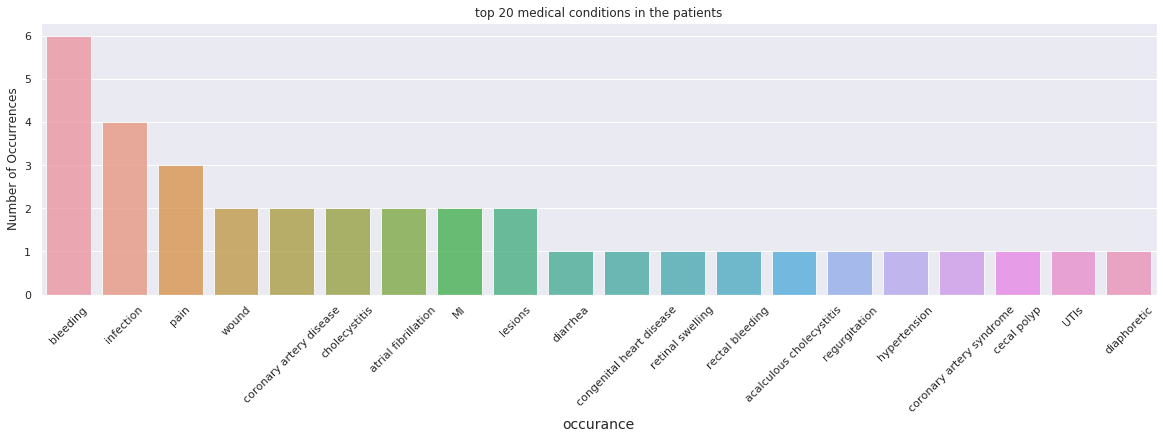

bleeding                   6
infection                  4
pain                       3
wound                      2
coronary artery disease    2
                          ..
Down syndrome              1
cervical spondylosis       1
masses                     1
pale                       1
distended                  1
Name: MEDICAL_CONDITION, Length: 69, dtype: int64

In [6]:
## organize into a dataframe
df_extracted_surg=extractMCbatch(df_phyList1,patient_ids)
## plot the results
topN=20 ## the number for top conditions
threshold_score=0.9
mc_barplot(df_extracted_surg, threshold_score,topN)

#### Randomly Select 200 patients from the *`Consult - History and Phy`*  category

In [7]:
%%time
nSample=20 ##<specify a number to process the medical terms in a batch >
medical_specialty=' Consult - History and Phy.'
df_phyList,patient_ids=subpopulation_comprehend(df, medical_specialty,sampleSize=nSample)

  0%|          | 0/20 [00:00<?, ?it/s]

original data shape is  (20, 8)
data shape after removing missing entries is  (20, 8)


100%|██████████| 20/20 [04:12<00:00, 12.63s/it]

CPU times: user 222 ms, sys: 24.9 ms, total: 247 ms
Wall time: 4min 12s


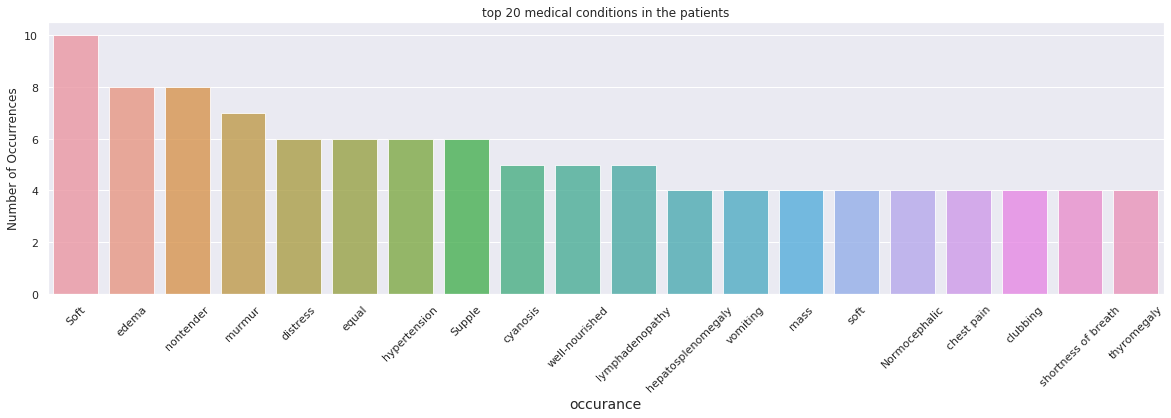

Soft                     10
edema                     8
nontender                 8
murmur                    7
distress                  6
                         ..
ground-level fall         1
helplessness              1
myocardial infarction     1
moist                     1
Awake                     1
Name: MEDICAL_CONDITION, Length: 376, dtype: int64

In [8]:
## organize into a dataframe
df_extracted_consult=extractMCbatch(df_phyList,patient_ids)
## plot the results
topN=20 ## the number for top conditions
threshold_score=0.9
mc_barplot(df_extracted_consult, threshold_score,topN)

## Combine the dataset into wide format

In [9]:
from imp import reload
from  util import preprocess
reload(preprocess)
#from util.preprocess import subpopulation_comprehend,retrieve_mcList

<module 'util.preprocess' from '/home/ec2-user/SageMaker/aws-ml-healthcare-workshop/util/preprocess.py'>

In [10]:
mcList1, df_grp1=preprocess.retrieve_mcList(df_extracted_surg)

In [11]:
mcList2, df_grp2=preprocess.retrieve_mcList(df_extracted_consult)

In [12]:
df_grp1['Label']=True # group one is Labeled as True 
df_grp2['Label']=False  # group two is Labeled as True 


df_combined=df_grp1.append(df_grp2) ## append two data frames 
mcLists=list(set(mcList1+mcList2))

df_combined2=preprocess.df_mc_generator(df_combined,mcLists ,colname_other=['ID',"Label"] )

## Save-the-File

In [13]:
df_combined2.to_csv("./data/processed_combined_wide_v1.csv",index=False)